# Learn VoC
### Pola Methodology

In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
from datetime import datetime
import numpy as np

In [2]:
batterySet = pickle.load(open("./Battery_Data/new_battery_cycles/new_battery_v2.p", 'rb'))

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

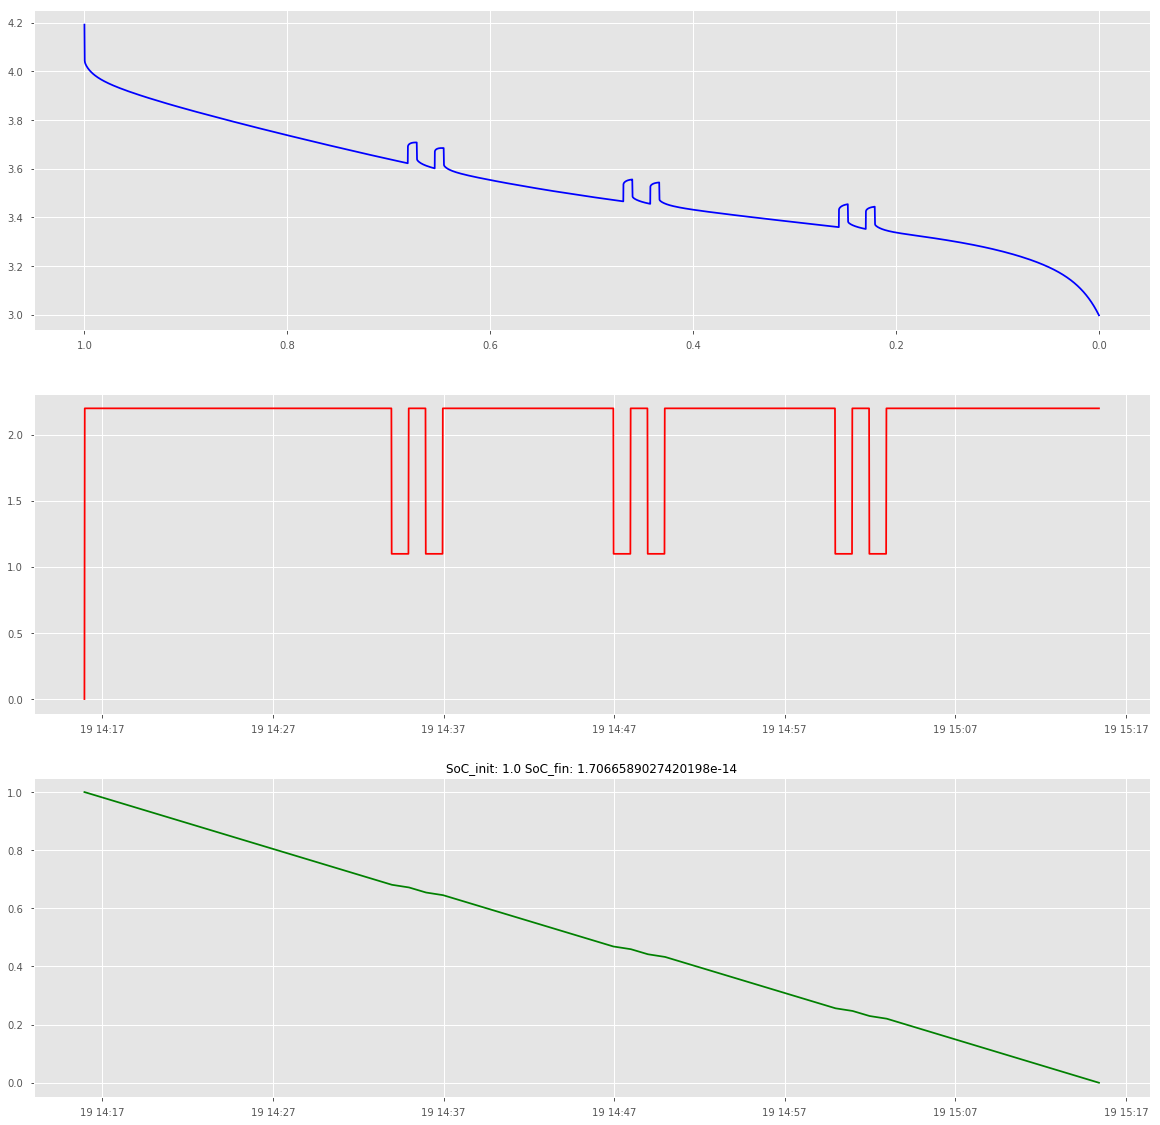

In [4]:
charSet = batterySet[1]
current = np.array(charSet['Current'], ndmin=2)*-1.0
seconds = np.ones_like(current)
C_n = np.sum(current*seconds)
SoC = []
SoC_state = 1.0
SoC_init = SoC_state
for i in range(current.shape[1]):
    SoC_state -= current[0, i]/C_n
    SoC.append(SoC_state)

Characterisation_Set = {}
Characterisation_Set['C_n'] = C_n
Characterisation_Set['SoC'] = np.array(SoC, ndmin=2)
Characterisation_Set['Current'] = current
Characterisation_Set['Voltage'] = charSet['Voltage']

matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
plt.figure("SoC Estimate")
plt.subplot(311)
plt.plot(SoC, charSet['Voltage'].T, '-b')
plt.gca().invert_xaxis()
plt.subplot(312)
plt.plot(charSet['datetime'].T, current.T, '-r')
plt.subplot(313)
plt.title("SoC_init: {0} SoC_fin: {1}".format(SoC_init, SoC[-1]))
plt.plot(charSet['datetime'].T, np.array(SoC), '-g')

## Define VoC
$|Z_p | = |\Delta V / \Delta I|$, assuming $v oc ( k ) = v ( k ) + i ( k )· Z_p$

In [5]:
high_low_index = []
low_high_index = []
for i in range(1, current.shape[1] - 1):
    if current[0, i] - current[0, i + 1] > 0.001:
        print("High -> Low", current[0, i], current[0, i+1])
        high_low_index.append(i)
    elif current[0, i + 1] - current[0, i] > 0.001:
        print("Low -> High", current[0, i], current[0, i+1])
        low_high_index.append(i)

High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09794 2.19783
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19783 1.09795
Low -> High 1.09795 2.19784
High -> Low 2.19784 1.09795
Low -> High 1.09795 2.19784


In [6]:
delta_V = np.abs(charSet['Voltage'][0, high_low_index]-charSet['Voltage'][0, low_high_index])
delta_I = np.abs(current[0, high_low_index]-current[0, low_high_index])
delta_Z = delta_V/delta_I
Z_p = np.mean(delta_Z)
print(Z_p)
print(high_low_index)
print(low_high_index)

0.08076263685971334
[1080, 1200, 1860, 1980, 2640, 2760]
[1140, 1260, 1920, 2040, 2700, 2820]


## Zone 2



In [7]:
SoC = np.array(SoC, ndmin=2)
voltage = charSet['Voltage']

(1, 2846)
(1, 2846) <class 'numpy.ndarray'>


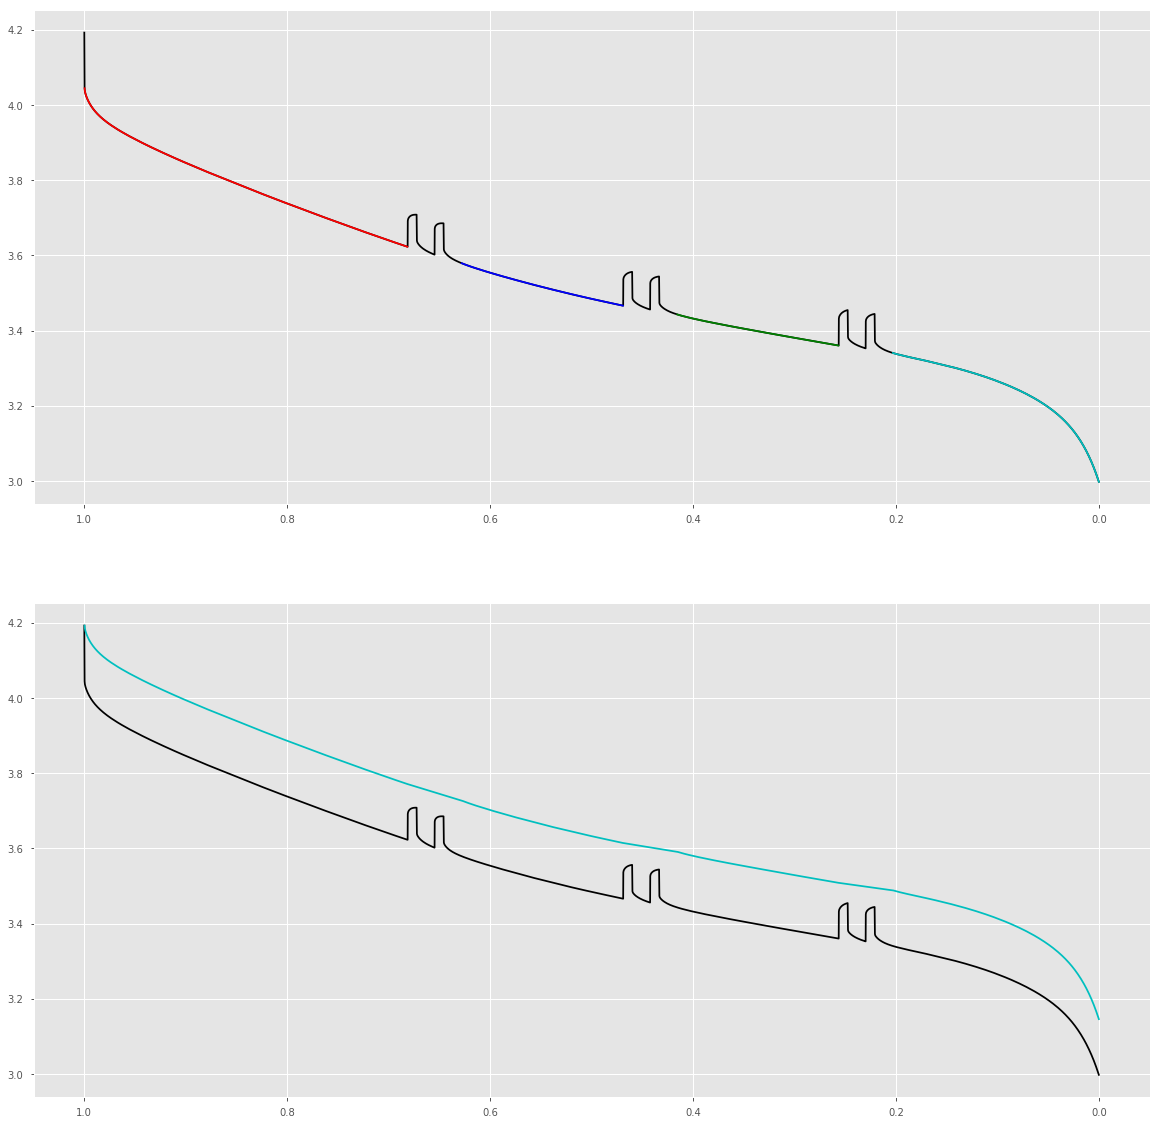

In [8]:
delta_t = low_high_index[0] + 1 - high_low_index[0]

l1_soc = SoC[0, 1:high_low_index[0]]
l1_v = voltage[0, 1:high_low_index[0]]

l2_soc = SoC[0, low_high_index[1]+delta_t:high_low_index[2]]
l2_v = voltage[0, low_high_index[1]+delta_t:high_low_index[2]]

l3_soc = SoC[0, low_high_index[3]+delta_t:high_low_index[4]]
l3_v = voltage[0, low_high_index[3]+delta_t:high_low_index[4]]

l4_soc = SoC[0, low_high_index[5]+delta_t:]
l4_v = voltage[0, low_high_index[5]+delta_t:]

SoC_smoothed = np.array(np.concatenate((l1_soc, l2_soc, l3_soc, l4_soc)), ndmin=2)
print(SoC_smoothed.shape)
V_smoothed = np.array(np.concatenate((l1_v, l2_v, l3_v, l4_v), axis=1), ndmin=2)
print(V_smoothed.shape, type(V_smoothed))

voc_gt = V_smoothed + voltage[0,0] - voltage[0, 1]

plt.subplot(211)
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(l1_soc.T, l1_v.T, '-r')
plt.plot(l2_soc.T, l2_v.T, '-b')
plt.plot(l3_soc.T, l3_v.T, '-g')
plt.plot(l4_soc.T, l4_v.T, '-c')
plt.gca().invert_xaxis()
plt.subplot(212)
plt.plot(SoC.T, voltage.T, '-k')
plt.plot(SoC_smoothed.T, voc_gt.T, '-c')
plt.gca().invert_xaxis()


### Robust Regression for the Pola Model

$$ v_{OC}(k) = v_L + (v_0 - v_L)\cdot e^{\gamma\cdot(SoC(k) - 1)} + \alpha\cdot v_L\cdot (SoC(k) - 1) + \ldots$$
$$ (1-\alpha)\cdot v_L\cdot \left(e^{-\beta} - e^{-\beta\sqrt{SoC(k)}}\right)$$

In [12]:
def VoC(SoC, v_L, v_0, gamma, alpha, beta):
    return v_L + (v_0 - v_L)*np.exp(gamma*(SoC - 1)) + alpha*v_L*(SoC - 1) \
            + (1 - alpha)*v_L*(np.exp(-beta) - np.exp(-beta*np.sqrt(SoC)))

In [1]:
from scipy.optimize import curve_fit

In [2]:
help(curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like or object
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, but can actually be any object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial guess for the parameters (length N).  If None, then the
        init

In [22]:
popt, pcov = curve_fit(VoC, SoC_smoothed[0, :], voc_gt[0, :])

In [23]:
popt

array([-1.59614486,  4.13646328,  0.63726463,  1.40174122,  2.54478965])

In [24]:
pcov

array([[ 3.20760703e-05, -1.42592964e-06, -1.05362732e-05,
        -2.33867619e-05,  2.94613475e-04],
       [-1.42592964e-06,  1.16631670e-07,  4.43229924e-07,
         7.70717994e-07, -9.87462369e-06],
       [-1.05362732e-05,  4.43229924e-07,  3.64782602e-06,
         8.71897886e-06, -1.06258574e-04],
       [-2.33867619e-05,  7.70717994e-07,  8.71897886e-06,
         2.37632680e-05, -2.86981690e-04],
       [ 2.94613475e-04, -9.87462369e-06, -1.06258574e-04,
        -2.86981690e-04,  3.61424434e-03]])

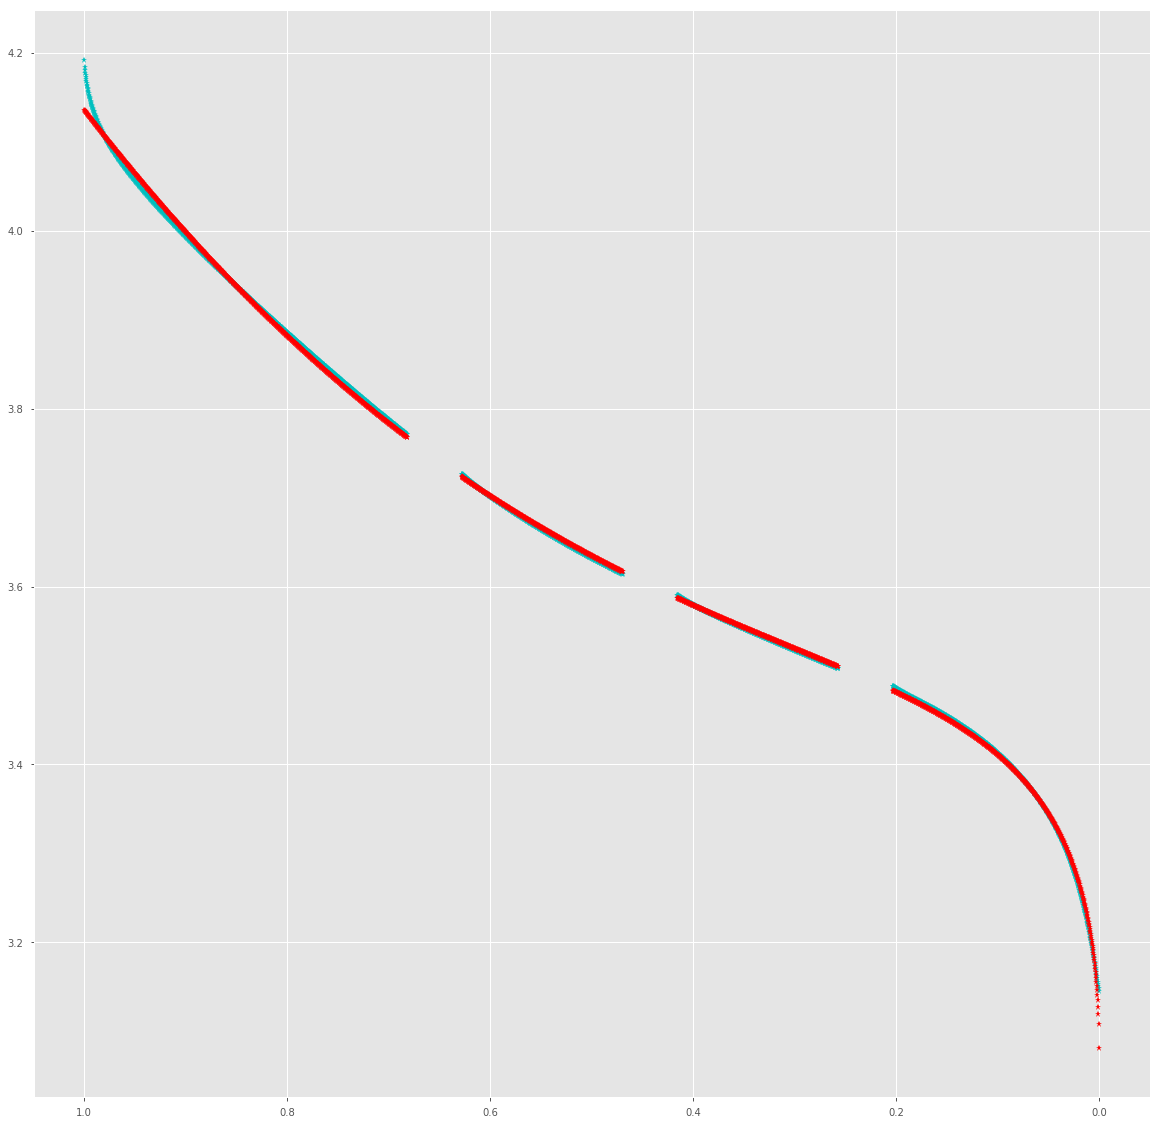

In [27]:
plt.plot(SoC_smoothed[0, :], voc_gt[0, :], '*c')
plt.plot(SoC_smoothed[0, :], VoC(SoC_smoothed[0, :], *popt), '*r')

plt.gca().invert_xaxis()

In [ ]:
def func(SoC, a,b,c,d,e,f,g):
    return a + b*SoC + c*np.power(SoC,2) + d*np.power(SoC,3) \
            + e*np.power(SoC,4) + f*np.power(SoC,5) + g*np.power(SoC,6)

In [ ]:
popt, pcov = curve_fit(func, SoC_smoothed[0, :], voc_gt[0, :])

In [ ]:
popt

In [ ]:
plt.plot(SoC_smoothed[0, :], func(SoC_smoothed[0, :], *popt), '-r')
plt.plot(SoC_smoothed[0, :], voc_gt[0, :], '.-c')

plt.gca().invert_xaxis()